In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy as sy
from scipy.integrate import odeint

In [2]:
phi,V0 = sp.symbols('phi V0',real =True)


V=V0*(sp.exp(phi)-1)**2
dVdphi = sp.diff(V,phi)
lam = -1/V *dVdphi

lam_simplified = sp.simplify(lam)
print("lam(phi) =", lam_simplified)
print(f"V' = {dVdphi}")

lam(phi) = 2*exp(phi)/(1 - exp(phi))
V' = 2*V0*(exp(phi) - 1)*exp(phi)


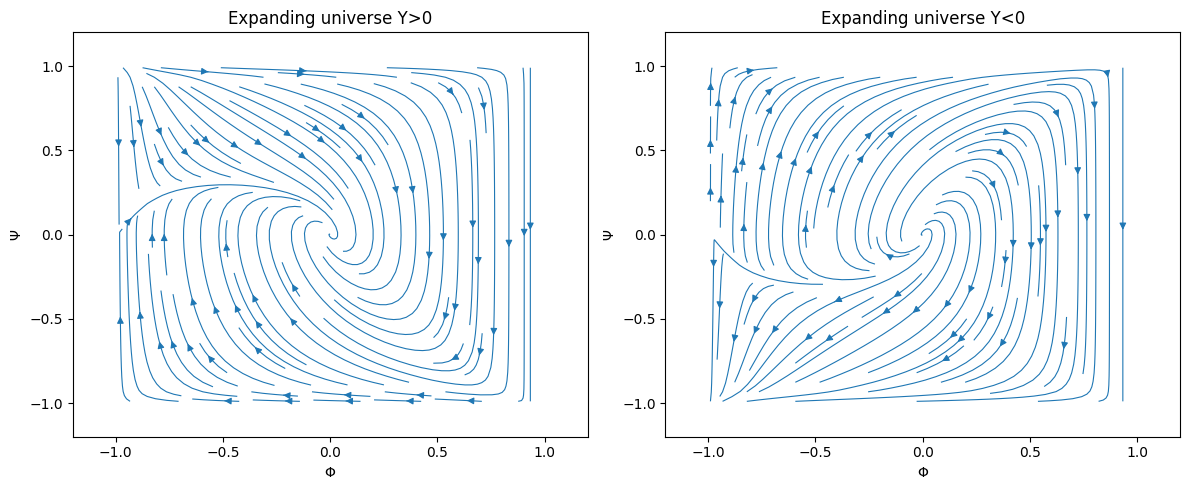

In [3]:
def dynamicsStateSpace(Phi,Psi,Y):
  phi = Phi/np.sqrt(1-Phi**2)
  dPsi = -3*Y*Psi*np.sqrt(1-Psi**2) -2*(1-Psi**2)**1.5 *np.exp(phi)*(np.exp(phi)-1)
  dPhi = (1-Phi**2)**(1.5) *Psi/(np.sqrt(1-Psi**2))
  
  
  
  return dPhi,dPsi

# defining a grid of points at which we create/compute tangent arrows
def vector_field_Y(Y):
  Phi = np.linspace(-0.99,0.99,30)# FP occur on hte boundary which relate to points going to infinity
  Psi = np.linspace(-0.99,0.99,30)
  PHI,PSI = np.meshgrid(Phi,Psi)
  dPHI = np.zeros(PHI.shape)
  dPSI = np.zeros(PSI.shape)

  for i in range(PHI.shape[0]): 
      for j in range(PHI.shape[0]): 
              a,b = dynamicsStateSpace(PHI[i,j], PSI[i,j],Y)
              dPHI[i,j] = a
              dPSI[i,j] = b
  return PHI,PSI,dPHI,dPSI
      

# Y>0 expanding, Y<0 contracting plots
def detect_FP(Y,temp=1e-10):
   grid =np.linspace(-0.99,0.99,30)
   FPs=[]

   for Phi in grid:
      for Psi in grid:
              dPhi,dPsi = dynamicsStateSpace(Phi, Psi,Y)
              norm = np.sqrt(dPhi**2 + dPsi**2)

              boundary= (abs(1-Phi**2)<temp or abs(1-Psi**2)<temp)

              if norm<temp or boundary:
                 p = np.array([Phi, Psi])
                 if not any(np.linalg.norm(p-q) < 0.15 for q in FPs):
                    FPs.append(p)

   return np.array(FPs)
         


def numerical_jacobian(F, x, Y, h=1e-6):
    x = np.array(x, dtype=float)
    J = np.zeros((2,2))

    for i in range(2):
        dx = np.zeros(2)
        dx[i] = h
        f1 = np.array(F(x[0]+dx[0], x[1]+dx[1], Y))
        f0 = np.array(F(x[0]-dx[0], x[1]-dx[1], Y))
        J[:, i] = (f1 - f0) / (2*h)

    return J

def classify_FP(J,temp=1e-10):
  eigvals=np.linalg.eigenvals(J)
  Real = np.real(eigvals)
  Imag = np.imag(eigvals)
  if np.all(Real<-temp):
    stability = 'Attractor'
  elif np.all(Real>temp):
    stability = 'Repeller'
  elif np.all(Real<-temp) and np.any(Real > temp):
    stability = 'saddle'
  elif np.all(np.abs(Real) < temp):
    stability = 'Centre'
  else:
    stability = 'NaN'
  if np.any(np.abs(Imag)>temp):
    point_type = 'Spiral'
  else:
    point_type = 'node'

  return stability,point_type, eigvals


fig,axes = plt.subplots(1,2,figsize=(12,5))

branches = {"Expanding universe Y>0":+0.5,"Expanding universe Y<0":-0.5}
for ax, (label,Yval) in zip(axes,branches.items()):
  PHI,PSI,dPHI,dPSI = vector_field_Y(Yval)
  ax.streamplot(PHI,PSI,dPHI,dPSI,density=1.2,linewidth=0.8)
  FPs= detect_FP(Yval)

  for fp in FPs:
     J=numerical_jacobian(dynamicsStateSpace,fp,Yval)
     stability,point_type, eigvals = classify_FP(J)
     print(rf"Y={Yval},Fixed points ={fp}, eigen values={eigvals}, stability ={stability}, point type={point_type}")
  ax.set_xlim(-1.2,1.2)
  ax.set_ylim(-1.2,1.2)
  ax.set_xlabel(rf"$\Phi$")
  ax.set_ylabel(rf"$\Psi$")
  ax.set_title(label)
plt.tight_layout()
plt.show()

